# Machine Learning Analysis

## Overview
In this section, we will cover the preprocessing steps that have already been done, including the creation of a price per square foot column, categorization of price ranges, outlier handling using the IQR method, normalization of price and area using Min-Max Scaling, and encoding of categorical variables such as builderName using Label Encoding and binary encoding for isUndisclosedAddress and isZillowOwned.

These transformations set the stage for applying machine learning models.

In [1]:
#Imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#Loading the Clean & Transformed Data
path = ('../data/cleaned_real_estate_data.csv')
real_estate_data = pd.read_csv(path)

In [ ]:
#Pull code from data cleaning notebook
#Create a new feature: price per square foot
#Ensure there are no zero or missing values in 'lot_area_sq_ft' to avoid division errors
#reduced_df['price_per_sq_ft'] = reduced_df['price'] / reduced_df['area']

#Handle infinite or NaN values (in case of missing or zero lot area)
#reduced_df['price_per_sq_ft'] = reduced_df['price_per_sq_ft'].replace([float('inf'), -float('inf')], np.nan)
#reduced_df['price_per_sq_ft'] = reduced_df['price_per_sq_ft'].fillna(0)

In [ ]:
#Categorization of Price Ranges
#reduced_df['price_range'] = pd.cut(
    #reduced_df['price'], 
    #bins=[0, 500000, 1000000, 5000000], 
    #labels=['Low', 'Medium', 'High']
#)


In [ ]:
#Outlier Test using IQR

# #Calculate Q1 (25th percentile) and Q3 (75th percentile)
# Q1 = reduced_df['price'].quantile(0.25)
# Q3 = reduced_df['price'].quantile(0.75)

# #Calculate IQR
# IQR = Q3 - Q1

# #Define lower and upper bounds for outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# #Filter the dataset to remove outliers
# reduced_df = reduced_df[(reduced_df['price'] >= lower_bound) & (reduced_df['price'] <= upper_bound)]

# #Print bounds for verification
# print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

In [ ]:
# Normalize Numerical Data
# scaler = MinMaxScaler()
# reduced_df[['price', 'area']] = scaler.fit_transform(reduced_df[['price', 'area']])


### Additional Preprocessing Steps for mL Models
- After initial preprocessing, there are a few more steps that need to be performed before applying the machine learning models. These steps ensure that the data is in the most optimal format for model training, especially when dealing with various types of models.

These steps include:
- Feature Engineering: Adding new features or transforming existing ones to improve model performance.
- Handling Categorical Variables: For models that don't accept categorical variables, we will convert them into numeric formats using techniques like One-Hot Encoding.
- Feature Selection: Identifying which features are most important for the model and potentially removing irrelevant ones.


In [3]:
#Feature selection: Dropping irrelevant or less important features
X = real_estate_data.drop(columns=['id', 'detailUrl', 'zpid','builderName', 'address'])


In [4]:
#One-Hot Encoding for categorical columns that are not already encoded (e.g.marketingStatusSimplifiedCd, price_range )
X = pd.get_dummies(X, columns=['marketingStatusSimplifiedCd', 'price_range'], drop_first=True)

In [5]:
#Ensure no missing values remain
X = X.fillna(X.mean())  # Replace missing values in numerical columns with the mean

In [6]:
#Re-split the data into training and testing sets
y = real_estate_data['price']  # Target variable (price)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Machine Learning Model Training (Shotgun Approach)
In this section, we will evaluate several base machine learning models to understand which one performs best. We will use the following models:

- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor
- Support Vector Machine Regressor (SVR)

We will assess their performance using metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R² to determine which model works best for predicting property prices.

In [7]:
#Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVM': SVR()
}


In [8]:
#Dictionary to store metrics
metrics = {'Model': [], 'MAE': [], 'MSE': [], 'R2': []}

In [9]:
#Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
     # Append metrics to dictionary
    metrics['Model'].append(name)
    metrics['MAE'].append(mae)
    metrics['MSE'].append(mse)
    metrics['R2'].append(r2)
    
    
    
    print(f'{name}: MAE = {mae:.2f}, MSE = {mse:.2f}, R2 = {r2:.2f}')
    

Linear Regression: MAE = 0.00, MSE = 0.00, R2 = 1.00
Decision Tree: MAE = 0.00, MSE = 0.00, R2 = 1.00
Random Forest: MAE = 0.00, MSE = 0.00, R2 = 1.00
SVM: MAE = 0.13, MSE = 0.04, R2 = 0.34


In [10]:
# Convert metrics dictionary to DataFrame
metrics_df = pd.DataFrame(metrics)


Linear Regression:
- The model achieved perfect predictions with MAE = 0.00, MSE = 0.00, and R² = 1.00, meaning it fits the data exactly. This could happen if the data is perfectly linear, or if the model is overfitting due to an issue like having the same number of features as data points.

Decision Tree:
- The Decision Tree also has perfect predictions, which can occur if the model memorized the data instead of learning patterns. This might happen if the tree is too deep, capturing every detail of the training data.

Random Forest:
- Random Forest shows perfect predictions, similar to the Decision Tree, possibly due to overfitting when there are too few data points or if the data is extremely easy to predict. However, this is unusual for Random Forests and might indicate over-tuning or issues in how the data is split.

SVM:
- SVM has lower performance (MAE = 0.13, MSE = 0.04, R² = 0.34), suggesting it struggled to learn patterns in the data. This could happen if the data is not separable in the chosen feature space or if the hyperparameters are poorly tuned.

### Hyperparameter Tuning and Model Optimization
- Once we have selected the best-performing base models, we will tune their hyperparameters to improve performance.
- Hyperparameter tuning can significantly improve model accuracy by adjusting parameters such as the number of trees in a Random Forest or the kernel type in an SVM.
- We will use GridSearchCV for exhaustive hyperparameter tuning and cross-validation to ensure the model generalizes well.

When the R² score is already 1 for the other models (Linear Regression, Decision Tree, and Random Forest), hyperparameter tuning might not add value unless overfitting is suspected. However, the SVM model needs improvement because of its relatively low R².

We will use GridSearchCV to find the best combination of hyperparameters for SVM. We'll tune parameters like:

- C (Regularization parameter): Balances the trade-off between achieving a low error on the training set and minimizing overfitting.
- Kernel (Type of SVM function): Determines how the data is mapped to a higher-dimensional space (e.g., linear, rbf, poly).
- Gamma (Kernel coefficient for rbf, poly, and sigmoid kernels): Controls the influence of single data points.

In [15]:
#Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}


In [16]:
#Initialize SVM model
svm_model = SVR()

In [17]:
#Set up GridSearchCV
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='r2', verbose=2)

#Fit the model to the training data
grid_search_svm.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=14.5min


In [ ]:
#Retrieve the best model
best_svm_model = grid_search_svm.best_estimator_

#Make predictions using the tuned model
y_pred_svm_tuned = best_svm_model.predict(X_test)

In [ ]:
#Evaluate the tuned model
mae_svm_tuned = mean_absolute_error(y_test, y_pred_svm_tuned)
mse_svm_tuned = mean_squared_error(y_test, y_pred_svm_tuned)
r2_svm_tuned = r2_score(y_test, y_pred_svm_tuned)

#Print results
print(f'Tuned SVM: MAE = {mae_svm_tuned:.2f}, MSE = {mse_svm_tuned:.2f}, R2 = {r2_svm_tuned:.2f}')

### Model Evaluation & Visualization
- After hyperparameter tuning, we evaluate the final model's performance.
- We will use relevant evaluation metrics (e.g., MAE, MSE, R²) and plot learning curves to visualize how the model performs during training and validation.
- We will also generate other useful visualizations, such as residual plots and feature importance charts, to understand how the model makes predictions and which features are most influential.


/var/folders/p9/l56kxrqj1f50k63kvkm8k0nm0000gp/T/ipykernel_22969/2590188112.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='MAE', palette='Blues_d')


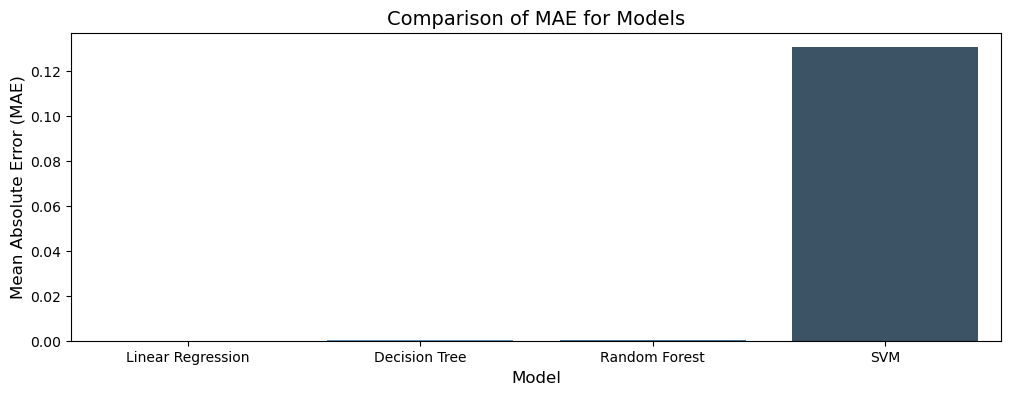

In [11]:
#MAE Comparison
plt.figure(figsize=(12, 4))
sns.barplot(data=metrics_df, x='Model', y='MAE', palette='Blues_d')
plt.title('Comparison of MAE for Models', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.show()


/var/folders/p9/l56kxrqj1f50k63kvkm8k0nm0000gp/T/ipykernel_22969/1669174443.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='MSE', palette='Greens_d')


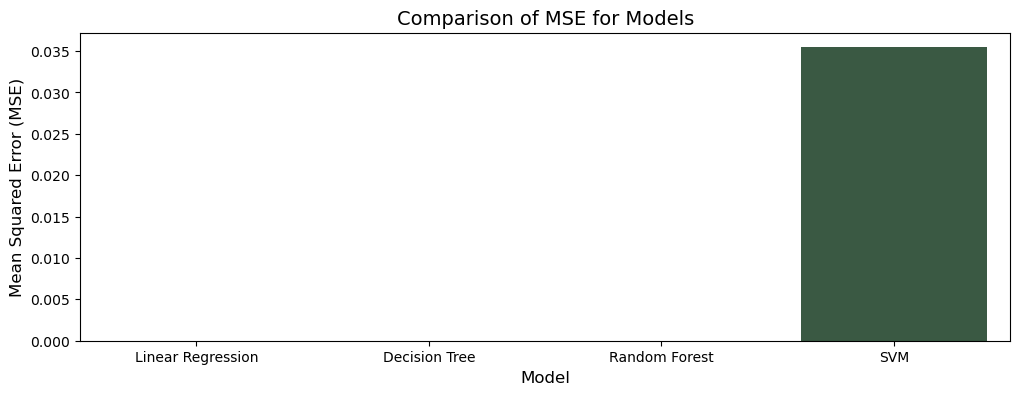

In [12]:
#MSE Comparison
plt.figure(figsize=(12, 4))
sns.barplot(data=metrics_df, x='Model', y='MSE', palette='Greens_d')
plt.title('Comparison of MSE for Models', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.show()

/var/folders/p9/l56kxrqj1f50k63kvkm8k0nm0000gp/T/ipykernel_22969/2785204433.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='R2', palette='Reds_d')


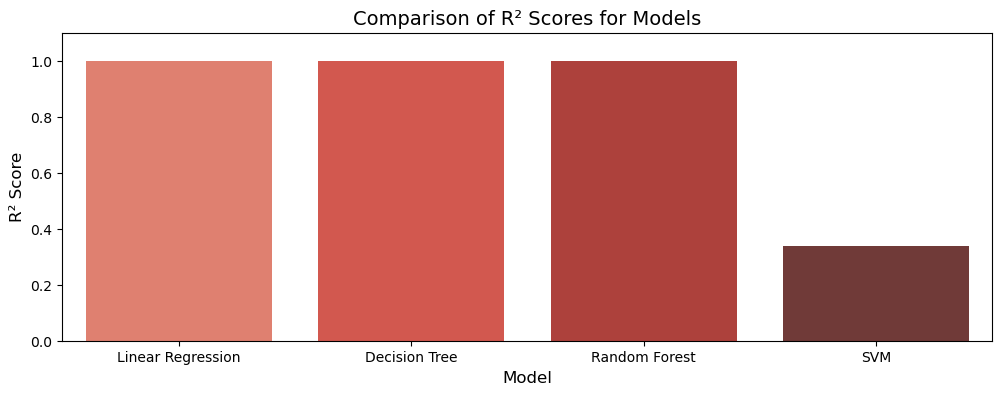

In [13]:
#R² Score Comparison
plt.figure(figsize=(12, 4))
sns.barplot(data=metrics_df, x='Model', y='R2', palette='Reds_d')
plt.title('Comparison of R² Scores for Models', fontsize=14)
plt.ylabel('R² Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1.1)  # Ensures a clear view of the R² range
plt.show()

In [ ]:
#Visualizing residuals
y_pred = best_svm_model.predict(X_test)
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title('Residuals of the Model')
plt.show()

In [ ]:
#Feature importance plot (for Random Forest)
feature_importances = best_svm_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=feature_importances)
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()